# Problem Set 1: Edges and Lines

In [11]:
import cv2 as cv
from matplotlib import pyplot as plt

## Question 1 - Store Edge Image

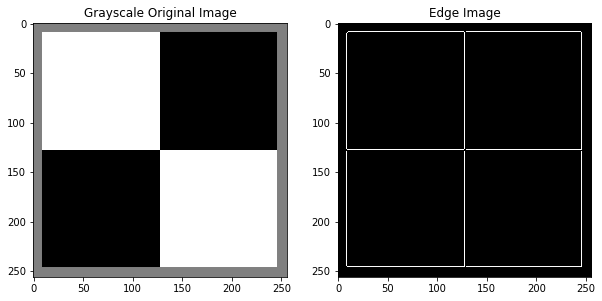

True

In [12]:
# Loads an image
image_grayscale = cv.imread("input/ps1-input0.png", cv.IMREAD_GRAYSCALE)

# Edge detection using Canny
edge_image = cv.Canny(
   image=image_grayscale,
   threshold1=50,
   threshold2=200,
   edges=None,
   apertureSize=3
)

fig, axs = plt.subplots(ncols=2, figsize=(10, 10), facecolor="white")
axs[0].imshow(image_grayscale, cmap="gray"), axs[0].set_title("Grayscale Original Image")
axs[1].imshow(edge_image, cmap="gray"), axs[1].set_title("Edge Image")
plt.show()

cv.imwrite("output/ps1-1-a-1.png", edge_image)

## Question 2 - Implementing Hough Transform
### a) Write a function hough_lines_acc that computes the Hough Transform for lines and produces an accumulator array.

In [ ]:
def hough_lines_acc():
   return 0


### b) Write a function hough_peaks that finds indices of the accumulator array (here line parameters) that correspond to local maxima.

In [ ]:
def hough_peaks():
   return 0

### c) Write a function hough_lines_draw to draw color lines that correspond to peaks found in the accumulator array.

In [ ]:
def hough_lines_draw():
   return 0

### d) What parameters did you use for finding lines in this image?